Origin-destination matrix estimation

In [1]:
import helper_functions

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

gdf = gpd.read_file("data/sources/Hungary_2022_static_road_data.geojson")

In [2]:
geo_positions = {
    "Budapest": (47.497912, 19.040235),
    "Kecskemét": (46.906770, 19.691383),
    "Szeged": (46.253000, 20.141424),
    "Szolnok": (47.172424, 20.178190),
    "Debrecen": (47.531605, 21.627312),
    "Nyíregyháza": (47.955879, 21.716837),
    "Miskolc": (48.104385, 20.791731),
    "Dunaújváros": (46.961511, 18.940582),
    "Szekszárd": (46.348886, 18.706048),
    "Pécs": (46.072734, 18.232266),
    "Székesfehérvár": (47.186644, 18.422595),
    "Siófok": (46.911703, 18.040138),
    "Győr": (47.687453, 17.634782),
    "Sopron": (47.686567, 16.588856),
    "Szombathely": (47.130884, 16.621046),
    "div_point_Miskolc_Debrecen": (47.7, 20.2),
    "div_point_Debrecen_Nyíregyháza": (47.6, 20.8),
    "div_point_Sopron_Szombathely": (47.4, 17.2),
    "Veszprém": (47.093658, 17.911332)
}
cities = ['Budapest', 'Kecskemét', 'Szeged', 'Szolnok', 'Debrecen', 'Nyíregyháza', 'Miskolc', 'Dunaújváros', 'Szekszárd', 'Pécs', 'Székesfehérvár', 'Siófok', 'Győr', 'Sopron', 'Szombathely', 'Veszprém']


## P-matrix for a small case: computing based on shortest paths

(give back all shortest paths, and 1/n on each path (+multiplicalities), 0 elsewhere..)

In [3]:
import pickle
with open("networks/Hungary_major_connections_upgraded_no_IDs.gpickle", "rb") as f:
    G_simple = pickle.load(f)

In [4]:
pos = {city: (lon, lat) for city, (lat, lon) in geo_positions.items()}#Just converting to dict (map) format for networkx

#Rename node names for better visualization
node_names = {city: city for city in pos.keys()}
node_names['div_point_Miskolc_Debrecen'] = 'd_M_D'
node_names['div_point_Debrecen_Nyíregyháza'] = 'd_D_Ny'
node_names['div_point_Sopron_Szombathely'] = 'd_S_Sz'

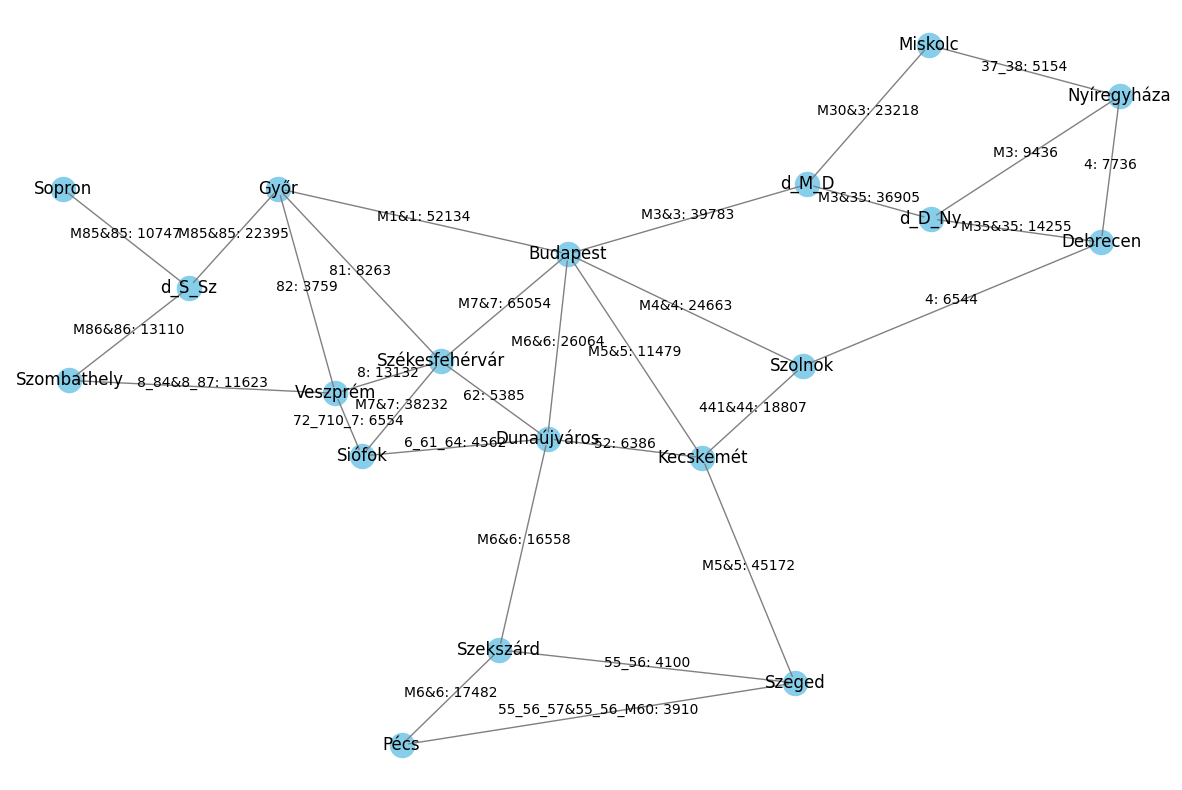

In [5]:
helper_functions.plot_map_simple_graph(G_simple, pos, node_names)

E.g. shortest paths:

In [6]:
roads = list(G_simple.edges())
road_traffics = [G_simple.get_edge_data(road[0], road[1])['weight'] for road in roads]

locations = list(G_simple.nodes())
#locations.remove('div_point_Miskolc_Debrecen'); locations.remove('div_point_Debrecen_Nyíregyháza'); locations.remove('div_point_Sopron_Szombathely')
shortest_paths_dict = {}
for i in range(len(locations)):
    source = locations[i]
    for j in range(i+1,len(locations)):
        target = locations[j]
        if source != target:
            paths = nx.all_shortest_paths(G_simple, source=source, target=target)
            shortest_paths_dict[(source, target)] = list(paths)

In [7]:
extra_paths = helper_functions.create_paths_dict([['Budapest', 'div_point_Miskolc_Debrecen', 'div_point_Debrecen_Nyíregyháza', 'Debrecen']])
hidden_locs = ['div_point_Miskolc_Debrecen', 'div_point_Debrecen_Nyíregyháza', 'div_point_Sopron_Szombathely']
v, P, odm, extra = helper_functions.v_P_odmbp_shortest_paths(G_simple, hidden_locations=hidden_locs, extra_paths_dict = extra_paths)
v_reduced, P_reduced, odm_reduced, extra_reduced = helper_functions.v_P_odmbp_reduced_matrix(G_simple, hidden_locations=hidden_locs, extra_paths_dict = extra_paths)

Sympy measured higher rank than numpy, extra steps are needed to take
Dependent rows: [[2, 10, 11]]
Independent rows count: 27, out of 30 rows
Amount of 1-length dependent groups: 0
Deleted rows list (index): [2]


There was an issue with Sympy giving different rank result than numpy (possibly the issue comes from digits accuracy). This seems to be fixed by the new approach.<br>
This is also stated here: [SymPy rank different from NumPy matrix rank](https://stackoverflow.com/questions/53792657/sympy-rank-different-from-numpy-matrix-rank)

In [8]:
np.linalg.matrix_rank(P_reduced), P_reduced.shape

(29, (29, 120))

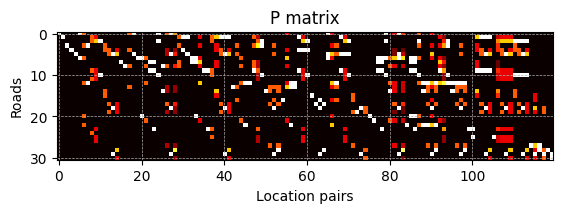

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
cax = ax.imshow(P, cmap='hot', interpolation='nearest')
#fig.colorbar(cax)
ax.set_title('P matrix')
ax.set_xlabel('Location pairs')
ax.set_ylabel('Roads')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [10]:
#from scipy.io import savemat

#Save the P matrix in a .mat file
#savemat('computing/P/P_matrix_16_cities.mat', {'P': P})
np.savetxt("computing/P/P_matrix_16_cities.csv", P, delimiter=",", fmt='%.3f')
np.savetxt("computing/P/P_matrix_reduced_16_cities.csv", P_reduced, delimiter=",", fmt='%.3f')

### P-matrix: Weighted shortest N paths - or A* 

TODO

## Constrainted optimization: SciPy

**NOTE**: We need to try out stronger solvers, as SciPy really only optimizes locally.

A pre-computed ODM (although for a different equation):

In [11]:
odm_entropy_max_previous_df = pd.read_csv("computing/odm/ODM_16_cities_entropy_max_previous.csv")
loc_pairs_pre = odm_entropy_max_previous_df['location_pair']
odm_entropy_max_previous = odm_entropy_max_previous_df['ODM_value']

Initial steps:

In [12]:
from scipy.optimize import minimize, Bounds, LinearConstraint

#Objective function
def entropy_max(odm):
    #Entropy maximizing (== minimizing the negative entropy)
    odm_nonzero = odm[odm != 0] #To avoid log(0) error
    return np.sum(odm_nonzero * np.log(odm_nonzero))

def entropy_max_derivative(x):
    y = [-np.inf if i == 0 else np.log(i) + 1 for i in x]
    return np.array(y)

def entropy_min(odm):
    odm_nonzero = odm[odm != 0] #To avoid log(0) error
    return -np.sum(odm_nonzero * np.log(odm_nonzero))

def entropy_min_derivative(x):
    y = [np.inf if i == 0 else -np.log(i)-1 for i in x]
    return np.array(y)

#Constraint(s)
constraints_linear = LinearConstraint(P_reduced, lb=v_reduced, ub=v_reduced)
#def constraint_eq_reduced(odm):
#    return P_reduced @ odm - v_reduced
#def constraint_eq(odm):
#    return P @ odm - v
#constraints = {'type': 'eq', 'fun': constraint_eq}
#constraints_reduced = {'type': 'eq', 'fun': constraint_eq_reduced}

bounds = Bounds(0, 100000) #np.inf

#### Entropy maximization

Turns out a full 1s initial O-D matrix makes this pretty bad. All values are < 10, got stuck in a local minimum.<br>
A better initial guess helps.

Let's try with `odm_entropy_max_previous`.

In [13]:
result = minimize(entropy_max, odm_entropy_max_previous, constraints=constraints_linear, bounds=bounds) #jac=entropy_derivative
optimal_odm = result.x
print('Success:', result.success)
print('Message:', result.message)
optimal_odm_list = []
for i in range(10):
    res = minimize(entropy_max, optimal_odm, constraints=constraints_linear, bounds=bounds, jac = entropy_max_derivative)
    optimal_odm = res.x
    optimal_odm_list.append(optimal_odm)
    print('Message:', res.message)
    if res.message == 'Inequality constraints incompatible':
        break

Success: False
Message: Iteration limit reached
Message: Inequality constraints incompatible


I believe the incompatibility comes from already hitting the local minimum.

In [14]:
odm_entropy_max = optimal_odm_list[-1]
df1 = pd.DataFrame({
    #'location_pair': extra_reduced['location_pairs'],
    'origin': [pair[0] for pair in extra_reduced['location_pairs']],
    'destination': [pair[1] for pair in extra_reduced['location_pairs']],
    'ODM_value': odm_entropy_max
})
df1.to_csv('computing/odm/ODM_16_cities_entropy_max.csv', index=False)

Looking into it, entropy maximization doesn't really seem like a good method.. it puts too much weight on far distances.

#### Entropy minimization

In [15]:
result = minimize(entropy_min, odm_entropy_max_previous, constraints=constraints_linear, bounds=bounds,) #jac=entropy_derivative
optimal_odm = result.x
print('Success:', result.success)
print('Message:', result.message)
optimal_odm_list = []
for i in range(10):
    res = minimize(entropy_min, optimal_odm, constraints=constraints_linear, bounds=bounds, jac = entropy_min_derivative)
    optimal_odm = res.x
    optimal_odm_list.append(optimal_odm)
    print('Message:', res.message)
    if res.message == 'Inequality constraints incompatible':
        break

Success: False
Message: Iteration limit reached
Message: Inequality constraints incompatible


In [16]:
odm_entropy_min = optimal_odm_list[-1]
df2 = pd.DataFrame({
    #'location_pair': extra_reduced['location_pairs'],
    'origin': [pair[0] for pair in extra_reduced['location_pairs']],
    'destination': [pair[1] for pair in extra_reduced['location_pairs']],
    'ODM_value': odm_entropy_min
})
df2.to_csv('computing/odm/ODM_16_cities_entropy_min.csv', index=False)

### Comparison

<module 'matplotlib.pyplot' from 'c:\\Users\\hanic\\.pyenv\\pyenv-win\\versions\\3.10.11\\lib\\site-packages\\matplotlib\\pyplot.py'>

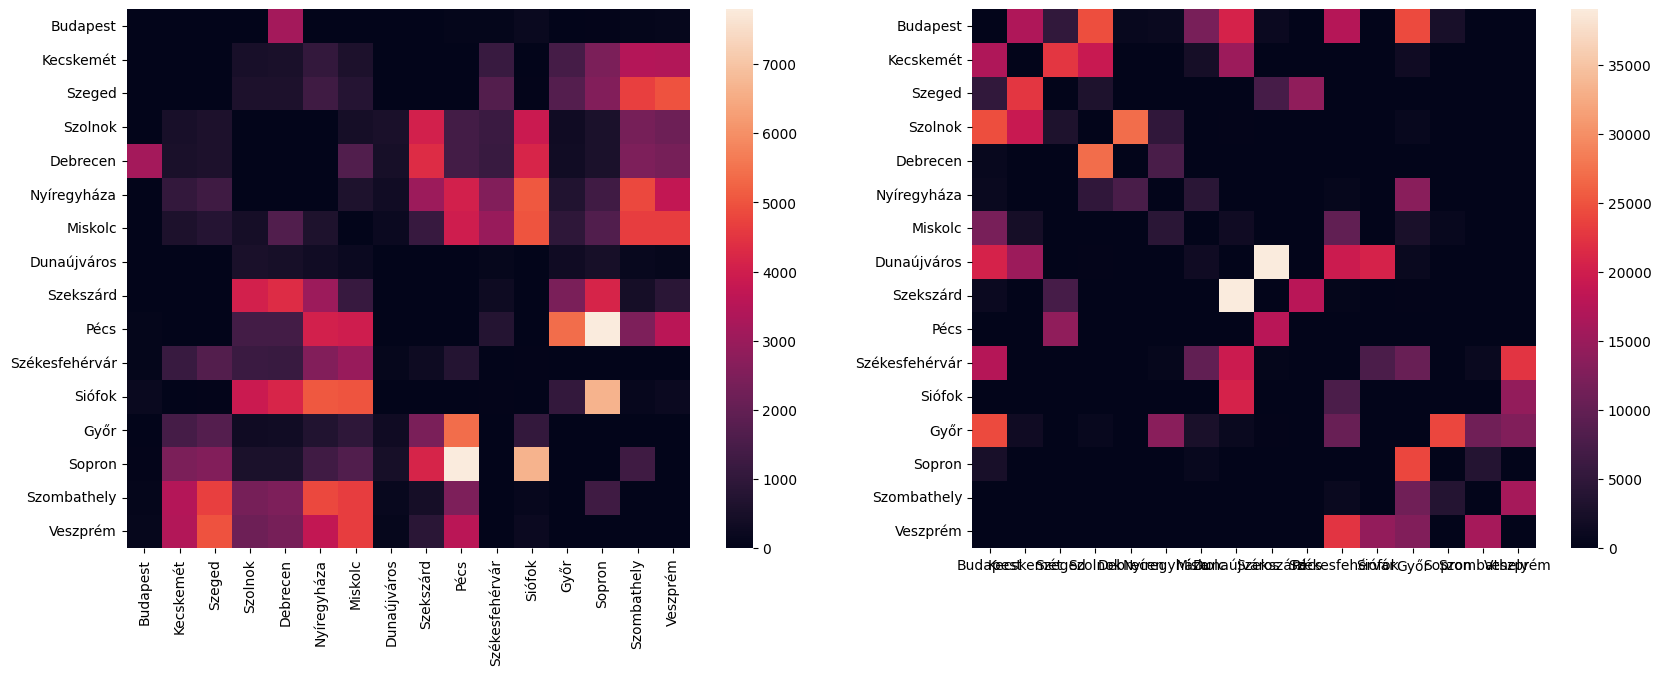

In [17]:
odm_entopy_max_2d,odm_locations = helper_functions.get_odm_2d_symmetric(odm = odm_entropy_max, location_pairs=extra_reduced['location_pairs'])
odm_entopy_min_2d,odm_locations = helper_functions.get_odm_2d_symmetric(odm = odm_entropy_min, location_pairs=extra_reduced['location_pairs'])

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
helper_functions.plot_odm_axis(odm_entopy_max_2d, odm_locations, order = cities, ax = ax[0])
helper_functions.plot_odm_axis(odm_entopy_min_2d, odm_locations, order = cities, ax = ax[1])

### Non-SciPy tools

Because SciPy is not very good at global optimization, we will need to try other methods.

#### CyIPOPT

Currently being tried to be installed.

<details><summary>Code</summary>

```python

import numpy as np
import cyipopt

#Entropy maximizing
def eval_f(x, user_data=None):
    return np.sum(x * np.log(x))

#Gradient
def eval_grad_f(x, user_data=None):
    return np.log(x) + 1

#Constraints
def eval_g(x, user_data=None):
    return P_reduced @ x - v_reduced

#Jacobian of the constraints
def eval_jac_g(x, flag,): #user_data=None
    if flag:
        return np.nonzero(P_reduced)
    else:
        return P_reduced.flatten()

constraints = [{'type': 'eq', 'fun': eval_g, 'jac': eval_jac_g}]
#Bounds (for each dimension of the input) 
bounds = [(0.001, 100000) for _ in range(len(odm_entropy_max_previous))]

nlp = cyipopt.Problem(
    n=len(odm_entropy_max_previous),
    m=len(P_reduced),
    problem_obj=eval_f,
    grad_obj=eval_grad_f,
    g=eval_g,
    jac_g=eval_jac_g,
    lb=[b[0] for b in bounds],
    ub=[b[1] for b in bounds],
)

x, info = nlp.solve(odm_entropy_max_previous)

```

</details>

## Regularized optimization

Instead of using constraints, we can use a regularized optimization, like L1 or L2 regularization.<br>
This way, we do not have to care about singularities, and we do not have to drop any constraint equations.

## Bell model

Bell modell: Maximize the joint probability of observing <u>t</u> assuming $\underline{v}=\underline{\underline{P}}\cdot\underline{t}$, given prior $\underline{q}$ probabilities that a trip occurs between some zone pair. (The assumption that trips are multinomially distibuted has to hold). This leads to the following optimization problem:

Optimize $$f(\underline{t}) = \frac{(\sum_j t_j)!}{\prod_j (t_j!)}\cdot \prod_j(q_j)^{t_j}$$

given $\underline{v}=\underline{\underline{P}}\cdot\underline{t}$ and $\underline{q}$. Because $\underline{q}$ is often unknown, one can take an initial guess for ODM values  $\underline{\tilde{t}}$ and set $\underline{q}=\underline{\tilde{t}}/\sum_j \tilde{t}_j$.

Working with factorials is not very feasible, so $F(\underline{t})=ln(f(\underline{t}))$ is defined. Using $\frac{d ln(x!)}{d x}=\ln(x)$ (see [here](https://math.stackexchange.com/a/3193982/1250920)), the partial derivatives of $F$ can be computed as $\frac{d F(\underline{t})}{d t_k} = \ln(\sum_j t_j) - \ln(t_k) + \ln(q_k)$.

The author solves the optimization problem with Lagrange multipliers. This way, we get a set of equations:

$$
L(\underline{t}, \underline{\lambda}) = F(\underline{t}) + \underline{\lambda}^T(\underline{v}-\underline{\underline{P}}\cdot\underline{t})\\

\frac{d F(\underline{t})}{d \underline{t}} = \underline{\lambda}^T \underline{\underline{P}}\\

\ln(t_k) = \ln(\sum_j t_j) + \ln(q_k) - \sum_j \lambda_j\cdot P_{jk}\\ t_k = (\sum_j t_j) \cdot q_k \cdot e^{\sum_j \lambda_j\cdot P_{jk}}
$$

Furthermore, for convenience, the author defines $\tau = \frac{\sum_j t_j}{\sum_j \tilde{t_j}}$, and $\ln\chi_i=-\lambda_i$. This way, we get: $t_k = \tau \cdot \tilde{t}_k \prod_i \chi_i^{P_{ik}}$.<br>The extra equation $\sum_j \tilde{t}_j = \tau^{-1} \sum_j t_j$ is added to the system of equations. We now have $I+1$ equations for $I+1$ unknowns: $\tau, \lambda_1, ..., \lambda_I$. Defining $\psi=\ln\tau$, we can rather look for $\psi$. The first unknown is found by the previously said equation, all others are found by:<br> ${v_i}=\sum_j p_{ij}{t_j} = \sum_j p_{ij}{\tilde{t_j}}e^{\psi-\sum_k \lambda_k p_{kj}}$ .

Not all equations are linearly independent however, so we assume only the $L$ equations that are linearly independent. Assuming those are the first $L$ equations (of $\underline{v}=\underline{\underline{P}}\cdot\underline{t}$). We just need to solve those, and get their lambda values, then extend for others. Then, the equations we have to compute for $\underline{t}$ are:

$$\underline{t} = \underline{\tilde{D}}\cdot e^{\underline{\underline{S}}^T \underline{\mu}}\\
\underline{\xi} = \underline{\tilde{\xi}} + \underline{\underline{S}}^T \underline{\mu^-}$$


where $\tilde{\underline{D}}$ is a diagonal matrix with $\tilde{t}_k$ on the diagonal, and $\underline{\underline{S}}$ is the matrix with [1, 1, ... 1] as first rows, and $P_{ik}$ as elements in the other rows, $\underline{\mu}$ is the vector of $\ln\tau$ and $\chi_i$ values, $\underline{\xi}$ is the vector of $\ln t_k$ values, and $\underline{\tilde{\xi}}$ is the vector of $\ln \tilde{t}_k$ values.


In our case...

We have conflicting equations, however, we do not want to throw away any of them. This way, we should use a regularized optimization method. Modifying $f$ is needed.

Let's divide the equations into two groups: The linearly independent ones, and the others. We keep the constraint to the independent ones, and use the others for the regularization. Thus: for linearly independent equations $v_{ind_i} = \sum_j P_{ij}t_j$, we assume them as constraints, and for the group of dependent terms, we will simply use the $|v_{dep_i} - \sum_j P_{ij}t_j|$ errors (with equal weights) in the regularization term. 

What would be the optimal loss function? If we are not careful we might choose a bad loss function. L2 grows quadratically, L1 grows linearly, and log-factorials grow $\mathcal{O}(x\ln x)$; this means that L2 will be too strong of an error. L1 might be a good choice as it is not too weak, but it isn't differentiable everywhere. We have two remaining options: Either a continuously derivative approximation of L1, such as $(error^2)^\frac{500}{999}$, or look for a function that grows asymptotically the same as log-factorials.<br>
I made a Math Stackexchange post [here](https://math.stackexchange.com/q/4916135/1250920) about finding functions of the latter, and I found $$g(\underline{|l|}) = \sum_j |l_j|\ln(|l_j|+1)$$ (where $l_j = v_j-\sum_k P_{jk}t_k$, the *j*-th error) to be a good candidate. It has a minimum at error=0, is even (as a function of error) because of the absolute values (so $-\Delta$ and $+\Delta$ error yields in equal loss), has order $O(x\ln x)$ (as the log-factorials), and it is once continuously differentiable. If we need double continuously differentiable / smoother functions, a user pointed out $\frac{x}{\pi }\arctan (x)\log (1 + x^2 )$ as a choice, but it has more complex derivatives. (The order of log-factorials is $O(x\ln x)$ because if it's derivatives are asymptotically equal to $\ln x$ as we saw before, and the integral of $\ln x$ is $x\ln x-x+c$.)<br>



Did not check how the Hessian and others change, but it would be good if we could use Lagrange multipliers again to get a closed form solution.<br>
L1 regularization in F will also be tried.

Read in the KSH data, gravity models

In [18]:
odm_KSH_df = (pd.read_csv("data/sources/KSH/flows_16_cities.csv"))
place_id_dict = {
    "Budapest": 13578,"Kecskemét": 26684,"Szeged": 33367,"Szolnok": 27854,
    "Debrecen": 15130,"Nyíregyháza": 17206,"Miskolc": 30456,"Dunaújváros": 3115,
    "Szekszárd": 22761,"Pécs": 19415,"Székesfehérvár": 14827,"Siófok": 17631,
    "Győr": 25584,"Sopron": 8518,"Szombathely": 3009,"Veszprém": 11767
}
id_place_dict = {v: k for k, v in place_id_dict.items()}
odm_KSH_df['origin'] = odm_KSH_df['origin'].apply(lambda x: id_place_dict[x])
odm_KSH_df['destination'] = odm_KSH_df['destination'].apply(lambda x: id_place_dict[x])
odm_KSH_df = odm_KSH_df[odm_KSH_df['origin'] != odm_KSH_df['destination']]
odm_KSH_df = helper_functions.sort_odm_loc_names_df(odm_KSH_df, extra_reduced['location_pairs'])
odm_KSH = np.array(odm_KSH_df['flow'])

In [19]:
odm_gravity_df = (pd.read_csv("computing/odm/ODM_16_cities_gravity_unfitted.csv"))
#Average out the flows between the same locations
#Temporary column
odm_gravity_df['od_pair'] = odm_gravity_df.apply(lambda row: tuple(sorted([row['origin'], row['destination']])), axis=1)

#Groupby this column, calculate the mean of the flow
odm_gravity_df = odm_gravity_df.groupby('od_pair').agg({'flow': 'mean'}).reset_index()

#Finally, split the 'od_pair' column back into 'origin' and 'destination'
odm_gravity_df[['origin', 'destination']] = pd.DataFrame(odm_gravity_df['od_pair'].tolist(), index=odm_gravity_df.index)
odm_gravity_df = (pd.concat([odm_gravity_df, odm_gravity_df], axis=0)).reset_index(drop=True)
for i in range(int(len(odm_gravity_df)/2), len(odm_gravity_df)):
    odm_gravity_df.at[i, 'origin'], odm_gravity_df.at[i, 'destination'] = odm_gravity_df.at[i, 'destination'], odm_gravity_df.at[i, 'origin']
odm_gravity_df = odm_gravity_df.drop(columns='od_pair')
#odm_gravity_df = odm_gravity_df[['origin', 'destination', 'flow']]

odm_gravity_df = helper_functions.sort_odm_loc_names_df(odm_gravity_df, extra_reduced['location_pairs'])

Divide the original constraints into independent (still kept as constraints) and dependent (used for regularization)

In [20]:
#Divide into dependent and independent rows
dep, indep = helper_functions.find_dependent_rows(P, return_independent=True)
dep = list(set([x for group in dep for x in group]))

P_dep = P[dep, :]; v_dep = v[dep]
P_indep = P[indep, :]; v_indep = v[indep]
#P_indep_padded = np.zeros((P.shape[0], P.shape[1])); v_indep_padded = np.zeros(v.shape)
#P_indep_padded[indep, :] = P_indep; v_indep_padded[indep] = v_indep

Dependent rows: [[2, 10, 11], [2, 10, 11, 24, 26]]
Independent rows count: 26, out of 31 rows
Amount of 1-length dependent groups: 0


In [21]:
import math

P_Bell_constraint = P_indep
v_Bell_constraint = v_indep
P_modified_loss = P_dep
v_modified_loss = v_dep
c = 0.01

odm_vector_tilde = odm_KSH
q = (odm_vector_tilde+0.0001)/np.sum(odm_vector_tilde+0.0001) #To avoid division by zero

initial_odm_vector = odm_entropy_min + 1 #Will try gravity model as initial guess too
constraints_linear = LinearConstraint(P_Bell_constraint, lb=v_Bell_constraint, ub=v_Bell_constraint)
bounds = Bounds(0.001, 100000) #np.inf

##################### Helper functions #####################
def log_factorial(n):
    #Roughly x*log(x) - x (their derivatives are asymptotically equal) - might as well use the simpler one in some cases
    return np.sum(np.log(np.arange(1, n+1)))

def log_factorial_float(x):
    return math.lgamma(x+1)
    
def sign(x):
    if x > 0: return 1
    elif x < 0: return -1
    else: return 0

##################### Objective functions #####################
def F_Bell(odm_vector):
    #Function to MAXIMIZE
    
    #The logarithm of the objective function, that maximizes the joint probability of observing t
    #subject to the constraints v_i = P_{ij}t_j, given the probabilities q and the assumption 
    #that trips are multinomially distributed.
    log_numerator = log_factorial_float(np.sum(odm_vector))
    log_denominator = np.sum([log_factorial_float(x) for x in odm_vector])
    log_probabilities = np.sum(odm_vector * np.log(q))
    return log_numerator - log_denominator + log_probabilities
def F_Bell_optimize(odm_vector):
    #Function to MINIMIZE
    return -F_Bell(odm_vector)

def F_Bell_modified(odm_vector):
    errors = P_modified_loss @ odm_vector - v_modified_loss
    loss = np.sum(np.abs(errors)*np.log(np.abs(errors)+1))
    return F_Bell(odm_vector) - c*loss
def F_Bell_modified_optimize(odm_vector):
    return -F_Bell_modified(odm_vector)

def F_Bell_L2(odm_vector): #"Overfits" on the loss. Likely unneccessary overfitting, constraints are strong enough
    #Objective function grows ~xln(x), but the loss grows ~x^2 -> too much emphasis on the loss
    loss = np.sum((P_modified_loss @ odm_vector - v_modified_loss)**2)
    return F_Bell(odm_vector) - c*loss
def F_Bell_L2_optimize(odm_vector):
    return -F_Bell_L2(odm_vector)

def F_Bell_L1(odm_vector): #Non-differentiable at 0 error
    loss = np.sum(np.abs(P_modified_loss @ odm_vector - v_modified_loss))
    return F_Bell(odm_vector) - c*loss
def F_Bell_L1_optimize(odm_vector):
    return -F_Bell_L1(odm_vector)

def F_Bell_L1_approximation(odm_vector): #Interpretation isn't clear
    k = 10000/9999
    loss = np.sum(np.power((P_modified_loss @ odm_vector - v_modified_loss)**2, k/2)) #First square, so it's always non-negative
    return F_Bell(odm_vector) - c*loss
def F_Bell_L1_approximation_optimize(odm_vector):
    return -F_Bell_L1_approximation(odm_vector)

##################### Partial derivatives (gradient) #####################
def F_Bell_gradient(odm_vector):
    t_sum = np.sum(odm_vector)
    return np.log(t_sum) - np.log(odm_vector) + np.log(q)
def F_Bell_optimize_gradient(odm_vector):
    #In case of minimization, we swap the signs
    return -F_Bell_gradient(odm_vector)

def F_Bell_modified_gradient(odm_vector):
    #See here: https://www.wolframalpha.com/input?i=d%28%7Cx%7Clog%28%7Cx%7C%2B1%29%29%2Fdx
    loss_gradient = np.zeros_like(odm_vector)
    for i in range(len(v_dep)): #All dependent equations, included in loss
        error_i = v_modified_loss[i]- P_modified_loss[i, :] @ odm_vector
        loss_i_derivative =  -(error_i/(np.abs(error_i)+1) + np.sign(error_i)*np.log(np.abs(error_i)+1))
        loss_gradient += P_modified_loss[i, :] * loss_i_derivative #Each column of P is an odm entry (so this is the vector already)
    return F_Bell_gradient(odm_vector) - c*loss_gradient
def F_Bell_modified_optimize_gradient(odm_vector):
    #In case of minimization, we swap the signs
    return -F_Bell_modified_gradient(odm_vector)

def F_Bell_L1_approximation_gradient(odm_vector): #Non-differentiable at 0 error
    k = 10000/9999
    loss_gradient = np.zeros_like(odm_vector)
    for i in range(len(v_dep)): #All dependent equations, included in loss
        error_i = v_modified_loss[i]- P_modified_loss[i, :] @ odm_vector
        loss_i_derivative =  k * error_i * np.power(np.abs(error_i), k-1)
        loss_gradient += P_modified_loss[i, :] * loss_i_derivative #Each column of P is an odm entry (so this is the vector already)
    return F_Bell_gradient(odm_vector) - c*loss_gradient
def F_Bell_L1_approximation_optimize_gradient(odm_vector):
    #In case of minimization, we swap the signs
    return -F_Bell_L1_approximation_gradient(odm_vector)

def F_Bell_L2_gradient(odm_vector): #"Overfits" on the loss. Likely unneccessary overfitting, constraints are strong enough
    #Objective function grows ~xln(x), but the loss grows ~x^2 -> too much emphasis on the loss
    loss_gradient = np.zeros_like(odm_vector)
    for i in range(len(v_dep)): #All dependent equations, included in loss
        error_i = v_modified_loss[i]- P_modified_loss[i, :] @ odm_vector
        loss_i_derivative =  2*error_i
        for k in range(len(odm_vector)): #Partial derivative by t_k
            loss_gradient[k] += P_modified_loss[i, k] * loss_i_derivative
    return F_Bell_gradient(odm_vector) - c*loss_gradient
def F_Bell_L2_optimize_gradient(odm_vector):
    #In case of minimization, we swap the signs
    return -F_Bell_L2_gradient(odm_vector)

### Bell #1:

- initial guess: entropy min
- with regularization

Let's run the optimization with the regularization term. The initial vector is the entropy minimized one.

In [22]:
result = minimize(F_Bell_modified_optimize, initial_odm_vector, constraints=constraints_linear, bounds=bounds, jac=F_Bell_modified_optimize_gradient)
optimal_odm = result.x
print('Success:', result.success)
print('Message:', result.message)

c:\Users\hanic\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Success: False
Message: Iteration limit reached


In [23]:
for i in range(100):
    odm_prev = optimal_odm
    res = minimize(F_Bell_modified_optimize, optimal_odm, constraints=constraints_linear, bounds=bounds, jac=F_Bell_modified_optimize_gradient)
    optimal_odm = res.x
    optimal_odm_list.append(optimal_odm)
    if res.message != 'Iteration limit reached':
        print('Message:', res.message)
    if (res.message == 'Inequality constraints incompatible') | (res.message == 'Positive directional derivative for linesearch'):
        break
    if odm_prev.astype(int).tolist() == optimal_odm.astype(int).tolist():
        break

In [24]:
optimal_odm.astype(int)

array([ 7099, 13197,  7568, 29258, 22984,  5641,  9391,  5786, 19897,
        8859, 19887,  9666,  5095, 10387, 13114,  6196,  5394,   374,
          96,  7154,   955,  1502,  2333,   187,    56,   745,   328,
          59,   207,   273,    45,   228,  6692,   633,   214,  3287,
         215,   376,   110,    38,   120,    96,  4725,   468,  3761,
        1311,  1195,   312,    45,    38,   253,  1144,    32,   161,
        6748,  1341,  2363,   619,   113,    42,   177, 14281,  7194,
        1390,   271,   118,   967,   539,   319,    75,   338,   863,
         558,  6421,  7403,  1773,  1184,  1952,   784,    53,  1938,
        1026,    74,   688,  2215,  1012,   361,    83,  1349,  1828,
         724,  2680,   515,     0,    20,   298,  1514,   257,   342,
        6854,  2007,   235,    33,   362,    30,  2415,    71,    44,
         100,    25,   123,     6,    97,   155,  5585,   567,   372,
         270,   770,  2225])

In [25]:
odm_bell_modified_df_from_entropy = odm_gravity_df.copy()
odm_bell_modified_df_from_entropy['flow'] = optimal_odm.astype(int)

The loss function seems to work, comparing to the Bell model:

### Bell #2:

- initial guess: entropy min
- without regularization

In [26]:
result = minimize(F_Bell_optimize, initial_odm_vector, constraints=constraints_linear, bounds=bounds, jac=F_Bell_optimize_gradient)
optimal_odm = result.x
print('Message:', result.message)
for i in range(100):
    odm_prev = optimal_odm
    res = minimize(F_Bell_optimize, optimal_odm, constraints=constraints_linear, bounds=bounds, jac=F_Bell_optimize_gradient)
    optimal_odm = res.x
    if res.message != 'Iteration limit reached':
        print('Message:', res.message)
    if (res.message == 'Inequality constraints incompatible') | (res.message == 'Positive directional derivative for linesearch'):
        break
    if odm_prev.astype(int).tolist() == optimal_odm.astype(int).tolist():
        break

Message: Iteration limit reached


In [27]:
optimal_odm.astype(int)

array([ 7047, 13896,  7571, 29400, 22969,  5659,  9365,  5760, 18331,
        8418, 19583,  9685,  5010, 10339, 13146,  5992,  5359,   373,
          95,  7201,   944,  1501,  2439,   195,    55,   731,   324,
          59,   204,   276,    48,   240,  6540,   607,   213,  3539,
         231,   405,   113,    39,   127,   101,  4696,   469,  3753,
        1320,  1186,   341,    44,    38,   249,  1139,    32,   158,
        6752,  1342,  2371,   613,   130,    40,   177, 14392,  7218,
        1385,   267,   118,   970,   537,   364,    71,   335,   850,
         532,  6368,  7431,  1734,  1179,  2062,   828,    52,  1912,
        1021,    74,   683,  2241,  1049,   374,    82,  1341,  1838,
         723,  2647,   554,     0,    20,   292,  1502,   255,   333,
        6818,  2062,   260,    38,   412,    35,  2481,    69,    42,
          95,    24,   122,     6,    96,   155,  5604,   558,   367,
         260,   753,  2221])

In [28]:
odm_bell_df_from_entropy = odm_gravity_df.copy()
odm_bell_df_from_entropy['flow'] = optimal_odm.astype(int)

### Bell #3:

- initial guess: gravity model
- with regularization

Let's see what values we get when we initialize with the gravity model.

In [29]:
initial_odm_vector = np.array(odm_gravity_df['flow'])

result = minimize(F_Bell_modified_optimize, initial_odm_vector, constraints=constraints_linear, bounds=bounds, jac=F_Bell_modified_optimize_gradient)
optimal_odm = result.x
print('Success:', result.success)
print('Message:', result.message)
for i in range(100):
    odm_prev = optimal_odm
    res = minimize(F_Bell_modified_optimize, optimal_odm, constraints=constraints_linear, bounds=bounds, jac=F_Bell_modified_optimize_gradient)
    optimal_odm = res.x
    if res.message != 'Iteration limit reached':
        print('Message:', res.message)
    if (res.message == 'Inequality constraints incompatible') | (res.message == 'Positive directional derivative for linesearch'):
        break
    if odm_prev.astype(int).tolist() == optimal_odm.astype(int).tolist():
        break

Success: False
Message: Iteration limit reached


In [30]:
optimal_odm.astype(int)

array([5029, 3197, 2557, 6027, 3067, 2512, 2139,  663, 2631, 1743, 3723,
        863, 1364,  632,  863,  670,  280,   74,   59,  680,   60,   50,
        114,   17,   49,   19,   57,   17,   21,   38,   14,   48,  456,
         28,   10,  225,   28,   83,    8,   16,   11,   10,  567,   62,
        125,  102,   61,   20,   10,   16,   19,   81,    1,    9,  512,
        100,  145,   25,   16,   11,   45,  500,  903,   48,   28,   46,
        104,   24,   30,   13,   55,   64,  266,  445,  376,  179,  118,
         59,   46,   29,   32,   59,   13,   28,  509,   20,   14,   23,
         52,   66,   35,   81,   10,    0,    2,    7,   36,    5,    6,
       2018,  718,    7,    6,   15,    1,  445,    6,   15,    7,    2,
         13,    2,    7,   12,  566,   29,   31,   53,   97,  481])

In [31]:
odm_bell_modified_df_from_gravity = odm_gravity_df.copy()
odm_bell_modified_df_from_gravity['flow'] = optimal_odm.astype(int)

### Bell #4:

- initial guess: gravity model
- without regularization

In [32]:
initial_odm_vector = np.array(odm_gravity_df['flow'])

result = minimize(F_Bell_optimize, initial_odm_vector, constraints=constraints_linear, bounds=bounds, jac=F_Bell_optimize_gradient)
optimal_odm = result.x
print('Success:', result.success)
print('Message:', result.message)
for i in range(100):
    odm_prev = optimal_odm
    res = minimize(F_Bell_optimize, optimal_odm, constraints=constraints_linear, bounds=bounds, jac=F_Bell_optimize_gradient)
    optimal_odm = res.x
    if res.message != 'Iteration limit reached':
        print('Message:', res.message)
    if (res.message == 'Inequality constraints incompatible') | (res.message == 'Positive directional derivative for linesearch'):
        break
    if odm_prev.astype(int).tolist() == optimal_odm.astype(int).tolist():
        break

Success: False
Message: Iteration limit reached


In [33]:
optimal_odm.astype(int)

array([5051, 3277, 2551, 5964, 3015, 2505, 2134,  656, 2473, 1580, 2905,
        848, 1377,  626,  848,  630,  272,   74,   60,  657,   59,   48,
        133,   21,   39,   19,   58,   17,   22,   38,   15,   50,  424,
         27,    9,  272,   35,   85,    8,   17,   12,   10,  561,   62,
        120,   98,   59,   24,   10,   12,   19,   81,    1,   10,  504,
         99,  143,   24,   21,   10,   35,  460,  883,   47,   29,   46,
        103,   24,   39,   11,   43,   63,  271,  436,  356,  177,  115,
         69,   55,   23,   32,   59,   13,   29,  496,   24,   17,   18,
         52,   66,   35,   84,   13,    0,    2,    7,   36,    5,    7,
       2008,  755,    9,    8,   20,    1,  457,    5,   14,    7,    1,
         10,    1,    5,    9,  555,   29,   32,   55,   99,  480])

In [34]:
odm_bell_df_from_gravity = odm_gravity_df.copy()
odm_bell_df_from_gravity['flow'] = optimal_odm.astype(int)

There is still a notable difference between values. If we start with `initial_odm_vector = np.array([90000]*len(odm_KSH))` we'd get a lot of large values (above 20000, even 50000).

As we see, there is still some bias, the optimizer cannot find the global minimum. I believe this happens, because while the logarithmic terms a concave (same for convex if multiplied by -1), we take away one from the other, which doesn't necessarily result in a concave function. Multiplying by -1, this might mean we have multiple local minima.

We might need to find solutions with Lagrange multipliers.

### Bell #5: only from gravity model

- initial guess: gravity model
- with regularization
- $q$ is not taken from KSH data, but from the gravity model

In [35]:
odm_vector_tilde = np.array(odm_gravity_df['flow'])
q = (odm_vector_tilde+0.0001)/np.sum(odm_vector_tilde+0.0001) #To avoid division by zero

initial_odm_vector = np.array(odm_gravity_df['flow'])+1

In [36]:
result = minimize(F_Bell_modified_optimize, initial_odm_vector, constraints=constraints_linear, bounds=bounds, jac=F_Bell_modified_optimize_gradient)
optimal_odm = result.x
print('Success:', result.success)
print('Message:', result.message)
for i in range(100):
    odm_prev = optimal_odm
    res = minimize(F_Bell_modified_optimize, optimal_odm, constraints=constraints_linear, bounds=bounds, jac=F_Bell_modified_optimize_gradient)
    optimal_odm = res.x
    optimal_odm_list.append(optimal_odm)
    if res.message != 'Iteration limit reached':
        print('Message:', res.message)
    if (res.message == 'Inequality constraints incompatible') | (res.message == 'Positive directional derivative for linesearch'):
        break
    if odm_prev.astype(int).tolist() == optimal_odm.astype(int).tolist():
        break

odm_bell_df_only_gravity = odm_gravity_df.copy()
odm_bell_df_only_gravity['flow'] = optimal_odm.astype(int)

Success: False
Message: Iteration limit reached


Writing it a different way, a bit less writing:

In [ ]:
model_func_args = {'q': q, 'c': c, 'P_modified_loss': P_dep, 'v_modified_loss': v_dep}


odm = helper_functions.optimize_odm(
    model_function=helper_functions.F_Bell_modified_optimize,
    odm_initial=initial_odm_vector,
    constraints_linear=constraints_linear,
    runs=101,
    model_func_args=model_func_args,
    bounds=bounds,
    model_derivative=helper_functions.F_Bell_modified_optimize_gradient,
    verbose=False, return_last=True
)

In [37]:
#Save the ODMs
odm_bell_modified_df_from_entropy.to_csv('computing/odm/ODM_16_cities_bell_modified_from_entropy.csv', index=False)
odm_bell_df_from_entropy.to_csv('computing/odm/ODM_16_cities_bell_from_entropy.csv', index=False)
odm_bell_modified_df_from_gravity.to_csv('computing/odm/ODM_16_cities_bell_modified_from_gravity.csv', index=False)
odm_bell_df_from_gravity.to_csv('computing/odm/ODM_16_cities_bell_from_gravity.csv', index=False)
odm_bell_df_only_gravity.to_csv('computing/odm/ODM_16_cities_bell_only_gravity.csv', index=False)